In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from DensePoisson import DensePoisson
from util import *
# visualize the results
import matplotlib.pyplot as plt

device = set_device()

Using device: cuda


In [ ]:
def train_network_init(net, optimizer_net, dataset, opts):
    
    epoch = 0
    u_res_init = net.u_init(dataset['x_res_train']) # initial value of u to help training
    while True:
        # Zero the gradients
        optimizer_net.zero_grad()
        
        res, res_D, u_pred = net.residual(dataset['x_res_train'], net.D)
        # Forward pass
        val_loss_res = mse(res)
        val_loss_D = mse(res_D)

        val_loss_data = mse(u_pred, u_res_init )

        
        val_loss_total = val_loss_res + val_loss_data + val_loss_D
        
        # Backward pass
        grads_net = torch.autograd.grad(val_loss_total, net.param_net, create_graph=True, allow_unused=True)
        
        for param, grad in zip(net.param_net, grads_net):
            param.grad = grad
        
        # Step the optimizers
        optimizer_net.step()
        
        # Output loss values up to three significant digits
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, PDE Loss: {val_loss_res.item():.3g}, Data Loss: {val_loss_data.item():.3g} Total Loss: {val_loss_total.item():.3g} D loss: {val_loss_D.item():.3g} D: {net.D.item():.3g}')

        # Termination conditions
        if val_loss_total.item() < opts['tolerance'] or epoch >= opts['max_iter']:
            break  # Exit the loop if loss is below tolerance or maximum iterations reached
        
        epoch += 1  # Increment the epoch counter



In [3]:
D_ext = 2
net = DensePoisson(2,64,p=1).to(device)

dataset = {}
dataset['x_res_train'] = torch.linspace(0, 1, 20).view(-1, 1).to(device)
dataset['x_res_train'].requires_grad_(True)

optimizer_net = optim.Adam(net.param_net, lr=0.001)  # Exclude D

In [ ]:


# opts for training
opts = {
    'tolerance': 1e-2,
    'max_iter': 100000
}

train_network_init(net, optimizer_net, dataset, opts)



In [ ]:
# Evaluate the trained neural network on a new grid
x_test = torch.linspace(0, 1, 50).view(-1, 1).to(device)

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

u_test = net(x_test)
u_init_test = net.u_init(x_test)


# plot diffeernt D value
Ds = [0.5, 1.0, 1.5, 2.0]
fig, ax = plt.subplots()

for i in range(len(Ds)):
    D = Ds[i]
    with torch.no_grad():
        net.D.data = torch.tensor([D]).to(device)
    u_test = net(x_test)
    ax.plot(x_test.cpu().numpy(), u_test.cpu().detach().numpy(), label='NN D = {}'.format(D),color=c[i])

    u_exact_test = net.u_exact(x_test, D)
    ax.plot(x_test.cpu().numpy(), u_exact_test.cpu().numpy(), label='exact D = {}'.format(D),color=c[i],linestyle='--')
# set net.D
ax.legend(loc="upper right")


# reset D to initial value
net.D.data = torch.tensor([net.init_D]).to(device)


In [ ]:
torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer_net.state_dict(),
            }, 'checkpoint.pth')

In [ ]:
checkpoint = torch.load('checkpoint.pth')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer_net.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
def train_network_inverse(net, optimizer_net, optimizer_D, dataset, opts):
    
    # Training loop
    epoch = 0
    while True:  # Change to a while loop to allow for early termination
        # Zero the gradients
        optimizer_net.zero_grad()
        optimizer_D.zero_grad()
        
        # Forward pass
        res, res_D, u_pred = net.residual(dataset['x_res_train'], net.D)
        # Forward pass
        val_loss_res = mse(res)
        val_loss_data = mse(u_pred, dataset['u_res_train'])
        val_loss_D = mse(res_D)
        
        val_loss_total = val_loss_res + val_loss_data + val_loss_D

        # Backward pass
        grads_net = torch.autograd.grad(val_loss_res + val_loss_D, net.param_net, create_graph=True, allow_unused=True)
        grads_pdeparam = torch.autograd.grad(val_loss_data, net.param_pde, create_graph=True, allow_unused=True)
        
        for param, grad in zip(net.param_net, grads_net):
            param.grad = grad
        
        for param, grad in zip(net.param_pde, grads_pdeparam):
            param.grad = grad

        # Step the optimizers
        optimizer_net.step()
        optimizer_D.step()

        # Output loss values up to three significant digits
        if epoch % 100 == 0:
            print_statistics(epoch, PDE=val_loss_res.item(), Data=val_loss_data.item(), Dloss=val_loss_D.item(), Total=val_loss_total.item(), D=net.D.item())

        # Termination conditions
        if val_loss_total.item() < opts['tolerance'] or epoch >= opts['max_iter']:
            break  # Exit the loop if loss is below tolerance or maximum iterations reached

        epoch += 1  # Increment the epoch counter




# set u_res for exact solution
Dexact = 2.0
dataset['u_res_train'] = net.u_exact(dataset['x_res_train'], Dexact)

opts['tolerance'] = 1e-3
optimizer_D = optim.Adam(net.param_pde, lr=0.0001)  # Only D

train_network_inverse(net, optimizer_net, optimizer_D, dataset, opts)


In [ ]:

# Evaluate the trained neural network on a new grid
x_test = torch.linspace(0, 1, 100).view(-1, 1).to(device)

u_test = net(x_test)
u_init_test = net.u_init(x_test)
u_exact_test = net.u_exact(x_test, Dexact)


# visualize the results
plt.figure()

plt.plot(x_test.cpu().numpy(), u_test.cpu().detach().numpy(), label='NN',marker='o')
plt.plot(x_test.cpu().numpy(), u_init_test.cpu().numpy(), label='init')
plt.plot(x_test.cpu().numpy(), u_exact_test.cpu().numpy(), label='exact')
plt.legend(loc="upper right")


In [5]:
def train_network_vanilla(net, optimizer_full, dataset, opts):
    # vanilla version of inverse problem
    epoch = 0
    u_res_init = net.u_init(dataset['x_res_train']) # initial value of u to help training
    while True:
        # Zero the gradients
        optimizer_full.zero_grad()
        
        res, res_D, u_pred = net.residual(dataset['x_res_train'], net.D)
        # Forward pass
        val_loss_res = mse(res)

        val_loss_data = mse(u_pred, dataset['u_res_train'] )

        val_loss_total = val_loss_res + val_loss_data
        
        # Backward pass
        val_loss_total.backward(retain_graph=True)
        
        # Step the optimizers
        optimizer_full.step()
        
        # Output loss values up to three significant digits
        if epoch % 100 == 0:
            print_statistics(epoch, PDE=val_loss_res.item(), Data=val_loss_data.item(), Total=val_loss_total.item(), D=net.D.item())

        # Termination conditions
        if val_loss_total.item() < opts['tolerance'] or epoch >= opts['max_iter']:
            break  # Exit the loop if loss is below tolerance or maximum iterations reached
        
        epoch += 1  # Increment the epoch counter


# opts for training
opts = {
    'tolerance': 1e-2,
    'max_iter': 100000
}
# set u_res for exact solution
Dexact = 2.0
dataset['u_res_train'] = net.u_exact(dataset['x_res_train'], Dexact)

# valila version
simplenet = DensePoisson(2,64, basic=True,p=1).to(device)
optimizer_full = optim.Adam(simplenet.parameters(), lr=0.001)  # Only D
train_network_vanilla(simplenet, optimizer_full, dataset, opts)


Epoch 0, PDE: 65.9, Data: 0.227, Total: 66.2, D: 0.999
Epoch 100, PDE: 0.116, Data: 0.104, Total: 0.22, D: 1.02
Epoch 200, PDE: 0.0118, Data: 0.105, Total: 0.117, D: 1.03
Epoch 300, PDE: 0.00146, Data: 0.103, Total: 0.105, D: 1.03
Epoch 400, PDE: 0.00103, Data: 0.1, Total: 0.101, D: 1.04
Epoch 500, PDE: 0.000991, Data: 0.0972, Total: 0.0982, D: 1.05
Epoch 600, PDE: 0.000954, Data: 0.0939, Total: 0.0949, D: 1.05
Epoch 700, PDE: 0.000916, Data: 0.0905, Total: 0.0914, D: 1.06
Epoch 800, PDE: 0.000877, Data: 0.087, Total: 0.0878, D: 1.07
Epoch 900, PDE: 0.000837, Data: 0.0834, Total: 0.0842, D: 1.08
Epoch 1000, PDE: 0.000797, Data: 0.0798, Total: 0.0806, D: 1.1
Epoch 1100, PDE: 0.000757, Data: 0.0762, Total: 0.0769, D: 1.11
Epoch 1200, PDE: 0.000716, Data: 0.0726, Total: 0.0733, D: 1.12
Epoch 1300, PDE: 0.000676, Data: 0.0691, Total: 0.0698, D: 1.13
Epoch 1400, PDE: 0.000637, Data: 0.0657, Total: 0.0664, D: 1.14
Epoch 1500, PDE: 0.000598, Data: 0.0624, Total: 0.063, D: 1.16
Epoch 1600, PDE

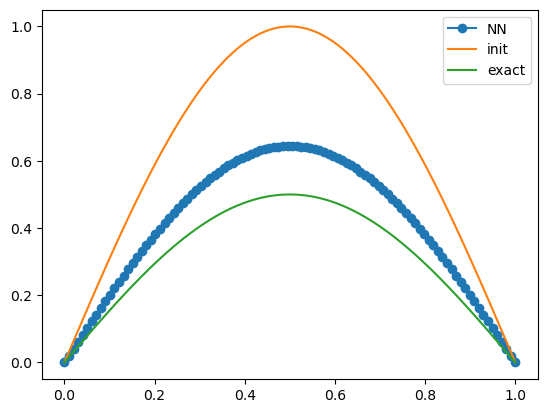

In [10]:
x_test = torch.linspace(0, 1, 100).view(-1, 1).to(device)

u_test = simplenet(x_test)
u_init_test = net.u_init(x_test)
u_exact_test = net.u_exact(x_test, Dexact)

plt.figure()

plt.plot(x_test.cpu().numpy(), u_test.cpu().detach().numpy(), label='NN',marker='o')
plt.plot(x_test.cpu().numpy(), u_init_test.cpu().numpy(), label='init')
plt.plot(x_test.cpu().numpy(), u_exact_test.cpu().numpy(), label='exact')
plt.legend(loc="upper right")